In [3]:
# ------------------------------------------------------------
!pip install lifelines

# ------------------------------------------------------------
import os, random, copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from lifelines import CoxPHFitter
from sklearn.model_selection import train_test_split

# ------------------------------------------------------------
RNG_SEED = 42
def seed_all(seed=RNG_SEED):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

seed_all(RNG_SEED)

# ------------------------------------------------------------
df = pd.read_csv("/content/drive/MyDrive/Paper(2025Dec)_SimulatedCVD/Data001_ReadyForCoxPH.csv")
for col in ["Unnamed: 0", "index"]:
    if col in df.columns:
        df = df.drop(columns=[col])
df_raw = copy.copy(df)

# ------------------------------------------------------------
train_df, test_df = train_test_split(
    df_raw, test_size=0.2, random_state=RNG_SEED, stratify=df_raw["cvd_event"]
)

# ------------------------------------------------------------
def build_X(df, drop_cols=None):
    df = df.copy()
    df["Age_c"] = df["Age"] - 30.0

    irsd = pd.get_dummies(df["IRSD_quintile"], prefix="irsd")
    if "irsd_5" in irsd.columns: irsd = irsd.drop(columns=["irsd_5"])

    smoke = pd.get_dummies(df["smoking_status"], prefix="smoke").fillna(0)
    if "smoke_non" in smoke.columns: smoke = smoke.drop(columns=["smoke_non"])

    for col in ["AF", "CKD", "diabetes", "cvd_event"]:
        df[col] = df[col].astype(int)

    X = pd.concat(
        [df[["Age_c","AF","CKD","diabetes","HbA1c","eGFR","SBP"]], smoke, irsd],
        axis=1
    )

    if drop_cols is None:
        events = df["cvd_event"].astype(bool)
        drop_cols = []
        for c in X.columns:
            v_all = X[c].var()
            v_e   = X.loc[events, c].var() if events.any() else 0.0
            v_ne  = X.loc[~events, c].var() if (~events).any() else 0.0
            if (v_all < 1e-6) or (v_e < 1e-6) or (v_ne < 1e-6):
                drop_cols.append(c)

    return X.drop(columns=drop_cols, errors="ignore"), drop_cols

# ------------------------------------------------------------
X_train, drop_cols = build_X(train_df, drop_cols=None)
train_surv = pd.concat([train_df[["cvd_time","cvd_event"]].reset_index(drop=True),
                        X_train.reset_index(drop=True)], axis=1).dropna()

cph = CoxPHFitter(penalizer=0.05)
cph.fit(train_surv, duration_col="cvd_time", event_col="cvd_event")


<lifelines.CoxPHFitter: fitted with 40000 total observations, 38393 right-censored observations>


=== Calibration at t=4.88 ===
a (slope) = 1.1609
D21(t)    = 0.1609
x when y=1 on fitted line (x = 1/a): 0.8614


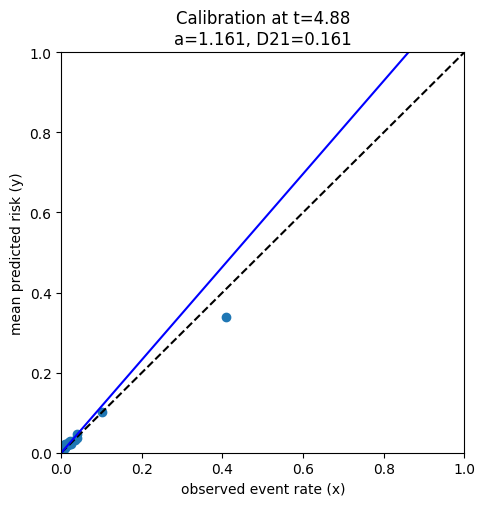

In [7]:
# ------------------------------------------------------------
X_test, _ = build_X(test_df, drop_cols=drop_cols)
test_surv = pd.concat([test_df[["cvd_time","cvd_event"]].reset_index(drop=True),
                       X_test.reset_index(drop=True)], axis=1).dropna()

y_time  = test_surv["cvd_time"].to_numpy(float)
y_event = test_surv["cvd_event"].to_numpy(int)
X_test_final = test_surv.drop(columns=["cvd_time","cvd_event"])

# ------------------------------------------------------------
t = 4.88
K = 20

S_t = cph.predict_survival_function(X_test_final, times=[t]).iloc[0].to_numpy(float)
risk_t = np.clip(1.0 - S_t, 0.0, 1.0)

y_by_t = ((y_event == 1) & (y_time <= t)).astype(int)

tmp = pd.DataFrame({"risk": risk_t, "y": y_by_t}).sort_values("risk").reset_index(drop=True)
tmp["bin"] = pd.qcut(tmp["risk"], q=K, duplicates="drop")
g = tmp.groupby("bin", observed=False)

r_bar = g["risk"].mean().to_numpy(float)   # x
y_bar = g["y"].mean().to_numpy(float)      # y

# ------------------------------------------------------------
a = float(np.dot(r_bar, y_bar) / np.dot(r_bar, r_bar))

x_at_y1 = float(1.0 / a) if a != 0 else np.nan

d21 = abs(1.0 - a)

print(f"\n=== Calibration at t={t:.2f} ===")
print(f"a (slope) = {a:.4f}")
print(f"D21(t)    = {d21:.4f}")
print(f"x when y=1 on fitted line (x = 1/a): {x_at_y1:.4f}")

# Plot
xs = np.linspace(0, 1, 200)
plt.figure(figsize=(5.2, 5.2))
plt.scatter(y_bar, r_bar)
plt.plot(xs, xs, linestyle="--",  c = 'black')
plt.plot(xs, a * xs, c = 'blue')
plt.xlim(0, 1); plt.ylim(0, 1)
plt.ylabel("mean predicted risk (y)")
plt.xlabel("observed event rate (x)")
plt.title(f"Calibration at t={t:.2f}\na={a:.3f}, D21={d21:.3f}")
plt.show()
